# **Importacion De Librerias y Datos**

In [40]:
import pandas as pd
import numpy as np

# Definir los tipos de dato para las columnas relevantes en df_salud
dtypes_salud = {
    'Nombre_Tipo_Atencion_Arp': 'category',
    'CODIGO_PROCEDIMIENTO': 'category',
    'TIPO_CITA': 'category',
    'Cantidad': 'float64',
    'TIPIFICACION': 'category',
    'Nombre_Sinies_Diagnosti_Princi': 'category',
    'Siniestro_Diagnosti_Princi_Id': 'category',
    'Nombre_Municipio_IPS': 'category',
    'Nombre_Departamento_IPS': 'category',
    'Geogra_Municipio_Id': 'category',
    'Tipo_Llamada_Arp_Desc': 'category',
    'Nombre_Establecimiento': 'category',
    'Dias_IT': 'float64'
}

# Seleccionar solo las columnas relevantes para df_salud
cols_to_use_salud = [
    'FECHA_ATENCION',              # Fecha y hora del servicio
    'Nombre_Tipo_Atencion_Arp',      # Tipo de atención
    'CODIGO_PROCEDIMIENTO',         # Código del procedimiento
    'TIPO_CITA',                   # Tipo de cita (ej. primera, seguimiento)
    'Cantidad',                    # Volumen o cantidad del servicio
    'TIPIFICACION',                # Clasificación adicional del servicio
    'Nombre_Sinies_Diagnosti_Princi',  # Diagnóstico principal (descriptivo)
    'Siniestro_Diagnosti_Princi_Id',     # Identificador del diagnóstico/siniestro
    'Nombre_Municipio_IPS',        # Municipio descriptivo de la IPS
    'Nombre_Departamento_IPS',     # Departamento descriptivo de la IPS
    'Geogra_Municipio_Id',         # Identificador estandarizado del municipio
    'Tipo_Llamada_Arp_Desc',       # Clasificación del tipo de llamada (si aplica)
    'Nombre_Establecimiento',      # Establecimiento donde se prestó el servicio
    'Dias_IT',                     # Días de incapacidad
    'FECHA_INICIO_INCAPACIDAD',    # Inicio de la incapacidad
    'FECHA_FIN_INCAPACIDAD'        # Fin de la incapacidad
]

# Leer el archivo CSV de df_salud
df_salud = pd.read_csv(
    "/kaggle/input/data-sura/1.Informacion Salud 2019-2024-001.txt",
    delimiter='|',
    usecols=cols_to_use_salud,
    dtype=dtypes_salud,
    parse_dates=['FECHA_ATENCION', 'FECHA_INICIO_INCAPACIDAD', 'FECHA_FIN_INCAPACIDAD'],
    na_values=['?', 'Dias_IT']
)

# Definir los tipos de dato para el dataset de prestadores
dtypes_prestadores = {
    'Geogra_Municipio_Id': 'category',
    'max_cantidad': 'float64'
}

# Seleccionar solo las columnas relevantes para df_prestadores
cols_to_use_prestadores = ['Geogra_Municipio_Id', 'max_cantidad']

# Leer el archivo CSV de df_prestadores
df_prestadores = pd.read_excel(
    "/kaggle/input/data-sura/2.Red Prestadores.xlsx",
    usecols=cols_to_use_prestadores,
    dtype=dtypes_prestadores
)

<ipython-input-40-da7238b2df53>:42: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_salud = pd.read_csv(


# **Analisis Exploratorio De Datos (EDA)**

In [41]:
# Vista previa de cada dataset
print("DF Salud:")
display(df_salud.head())
print("dtypes:")
print(df_salud.dtypes)


print("DF Prestadores:")
display(df_prestadores.head())
print("dtypes:")
print(df_prestadores.dtypes)

DF Salud:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Nombre_Sinies_Diagnosti_Princi,Siniestro_Diagnosti_Princi_Id,Nombre_Tipo_Atencion_Arp,Nombre_Municipio_IPS,Nombre_Departamento_IPS,Nombre_Establecimiento,FECHA_ATENCION,Tipo_Llamada_Arp_Desc,CODIGO_PROCEDIMIENTO,FECHA_FIN_INCAPACIDAD,FECHA_INICIO_INCAPACIDAD,TIPIFICACION,TIPO_CITA,Dias_IT,Cantidad,Geogra_Municipio_Id
0,G560,G560,AMBULATORIA,MEDELLIN,ANTIOQUIA,21539c4082,2019-07-12 06:20:00,CONTROL IPS,NaN,NaN,NaN,CITAS FRONT,NaN,NaN,1.0,586
1,S626,S626,QUIRURGICO AMBULATORIO,MEDELLIN,ANTIOQUIA,a8f2d23df3,2019-06-18 11:08:00,CONTROL PROCEDIMIENTO,FISI,NaN,NaN,CITAS BACK,C,NaN,2.0,586
2,S835,S835,QUIRURGICO AMBULATORIO,BOGOTA,BOGOTA D.C.,c91884bd59,2019-03-05 07:20:00,CONTROL IPS,NaN,NaN,NaN,CITAS BACK,C,NaN,1.0,586
3,M751,M751,QUIRURGICO AMBULATORIO,POPAYAN,CAUCA,03bda117d5,2019-10-05 10:03:00,CONTROL IPS,NaN,NaN,NaN,URGENCIAS FRONT,I,NaN,1.0,834
4,M545,M545,AMBULATORIA,SANTIAGO DE CALI,VALLE DEL CAUCA,fd38d78dc4,2019-06-25 07:13:00,CONTROL PROCEDIMIENTO,RSIM,2/07/2019,25/06/2019,URGENCIAS FRONT,I,8.0,1.0,2546


dtypes:
Nombre_Sinies_Diagnosti_Princi          category
Siniestro_Diagnosti_Princi_Id           category
Nombre_Tipo_Atencion_Arp                category
Nombre_Municipio_IPS                    category
Nombre_Departamento_IPS                 category
Nombre_Establecimiento                  category
FECHA_ATENCION                    datetime64[ns]
Tipo_Llamada_Arp_Desc                   category
CODIGO_PROCEDIMIENTO                    category
FECHA_FIN_INCAPACIDAD                     object
FECHA_INICIO_INCAPACIDAD                  object
TIPIFICACION                            category
TIPO_CITA                               category
Dias_IT                                  float64
Cantidad                                 float64
Geogra_Municipio_Id                     category
dtype: object
DF Prestadores:


,Geogra_Municipio_Id,max_cantidad
0,834,51.0
1,834,2.0
2,834,5961.0
3,834,1.0
4,834,1.0


dtypes:
Geogra_Municipio_Id    category
max_cantidad            float64
dtype: object


**Analisis de Valores Nulos Y Duplicados**

In [46]:
# Información general del DataFrame
print("Información de df_salud:")
df_salud.info()

# Estadísticas descriptivas (numéricas y algunas categóricas)
print("Estadísticas descriptivas de df_salud:")
display(df_salud.describe(include='all'))


Información de df_salud:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11716416 entries, 0 to 11716415
Data columns (total 16 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Nombre_Sinies_Diagnosti_Princi  category      
 1   Siniestro_Diagnosti_Princi_Id   category      
 2   Nombre_Tipo_Atencion_Arp        category      
 3   Nombre_Municipio_IPS            category      
 4   Nombre_Departamento_IPS         category      
 5   Nombre_Establecimiento          category      
 6   FECHA_ATENCION                  datetime64[ns]
 7   Tipo_Llamada_Arp_Desc           category      
 8   CODIGO_PROCEDIMIENTO            category      
 9   FECHA_FIN_INCAPACIDAD           object        
 10  FECHA_INICIO_INCAPACIDAD        object        
 11  TIPIFICACION                    category      
 12  TIPO_CITA                       category      
 13  Dias_IT                         float64       
 14  Cantidad               

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Nombre_Sinies_Diagnosti_Princi,Siniestro_Diagnosti_Princi_Id,Nombre_Tipo_Atencion_Arp,Nombre_Municipio_IPS,Nombre_Departamento_IPS,Nombre_Establecimiento,FECHA_ATENCION,Tipo_Llamada_Arp_Desc,CODIGO_PROCEDIMIENTO,FECHA_FIN_INCAPACIDAD,FECHA_INICIO_INCAPACIDAD,TIPIFICACION,TIPO_CITA,Dias_IT,Cantidad,Geogra_Municipio_Id
count,11716413,11716413,11716413,9918038,9918038,11716413,11716410,11229928,2341616,871573,871585,11716413,8718791,872853.000000,1.171642e+07,11716416
unique,954,954,8,384,32,2828,NaN,8,12,2311,2284,10,5,NaN,NaN,1096
top,G560,G560,AMBULATORIA,MEDELLIN,ANTIOQUIA,SIN DATO,NaN,CONTROL IPS,FISI,12/01/2022,13/01/2022,URGENCIAS FRONT,C,NaN,NaN,586
freq,561662,561662,6212549,6415140,6674509,3182106,NaN,6257236,1703568,793,847,3683921,5381480,NaN,NaN,2500073
mean,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-30 17:29:59.717806336,NaN,NaN,NaN,NaN,NaN,NaN,11.914541,1.327334e+00,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-30 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,1.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-11 12:40:00,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,1.000000e+00,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,1.000000e+00,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-31 22:35:00,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,9.600000e+01,NaN


In [44]:
# Valores nulos
df_salud.isnull().sum()

Nombre_Sinies_Diagnosti_Princi           3
Siniestro_Diagnosti_Princi_Id            3
Nombre_Tipo_Atencion_Arp                 3
Nombre_Municipio_IPS               1798378
Nombre_Departamento_IPS            1798378
Nombre_Establecimiento                   3
FECHA_ATENCION                           6
Tipo_Llamada_Arp_Desc               486488
CODIGO_PROCEDIMIENTO               9374800
FECHA_FIN_INCAPACIDAD             10844843
FECHA_INICIO_INCAPACIDAD          10844831
TIPIFICACION                             3
TIPO_CITA                          2997625
Dias_IT                           10843563
Cantidad                                 0
Geogra_Municipio_Id                      0
dtype: int64

In [45]:
df_prestadores.isnull().sum

<bound method DataFrame.sum of         Geogra_Municipio_Id  max_cantidad
0                     False         False
1                     False         False
2                     False         False
3                     False         False
4                     False         False
...                     ...           ...
298274                False         False
298275                False         False
298276                False         False
298277                False         False
298278                False         False

[298279 rows x 2 columns]>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


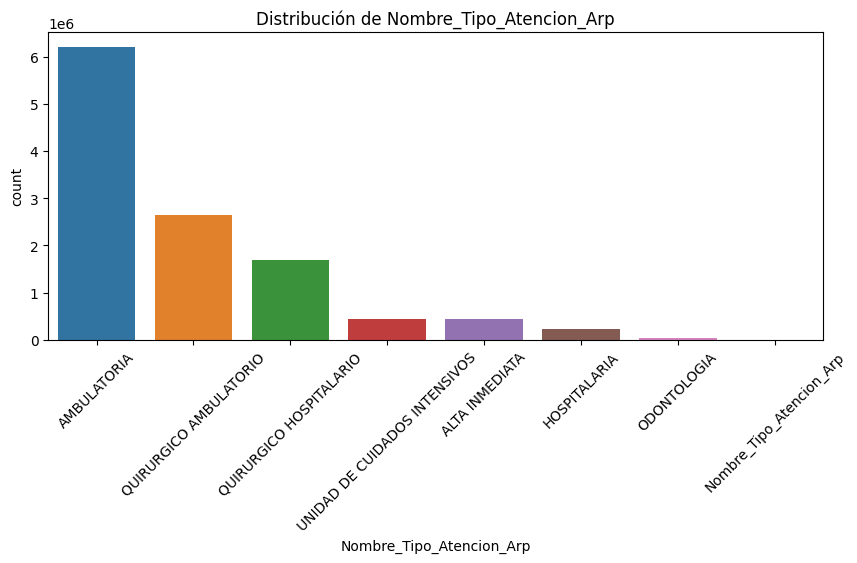

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


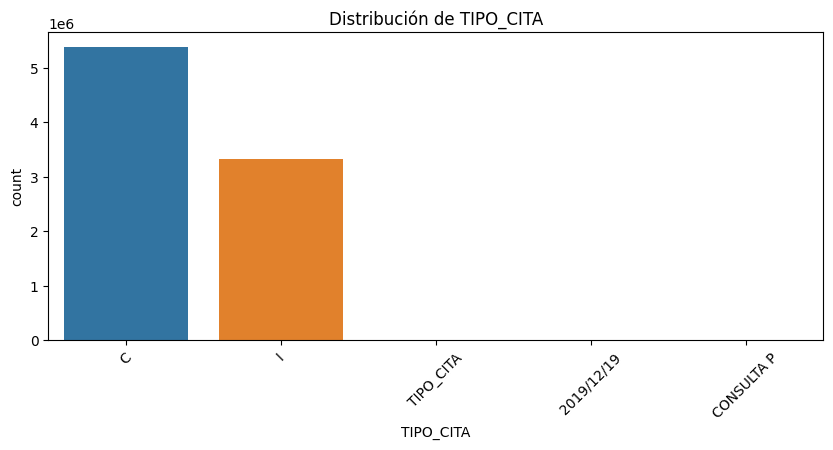

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


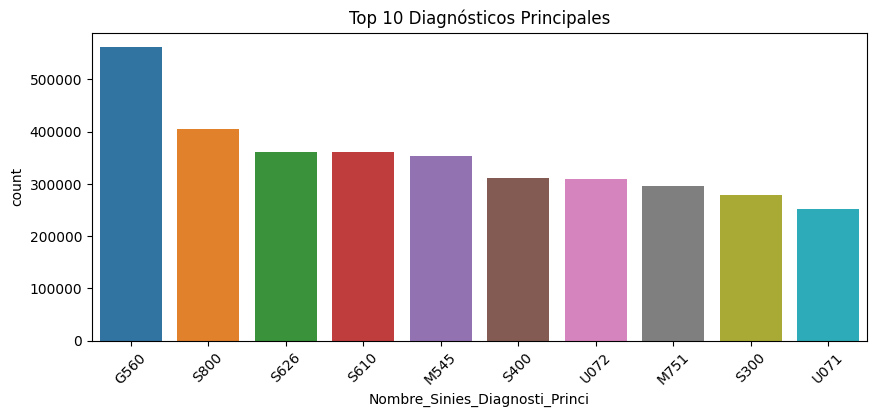

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de 'Nombre_Tipo_Atencion_Arp'
plt.figure(figsize=(10,4))
sns.countplot(data=df_salud, x='Nombre_Tipo_Atencion_Arp', order=df_salud['Nombre_Tipo_Atencion_Arp'].value_counts().index)
plt.title("Distribución de Nombre_Tipo_Atencion_Arp")
plt.xticks(rotation=45)
plt.show()

# Distribución de 'TIPO_CITA'
plt.figure(figsize=(10,4))
sns.countplot(data=df_salud, x='TIPO_CITA', order=df_salud['TIPO_CITA'].value_counts().index)
plt.title("Distribución de TIPO_CITA")
plt.xticks(rotation=45)
plt.show()

# Distribución de 'Nombre_Sinies_Diagnosti_Princi'
plt.figure(figsize=(10,4))
sns.countplot(data=df_salud, x='Nombre_Sinies_Diagnosti_Princi', order=df_salud['Nombre_Sinies_Diagnosti_Princi'].value_counts().iloc[:10].index)
plt.title("Top 10 Diagnósticos Principales")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


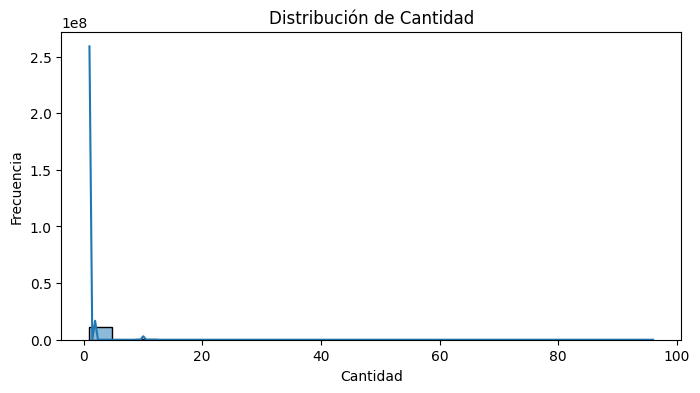

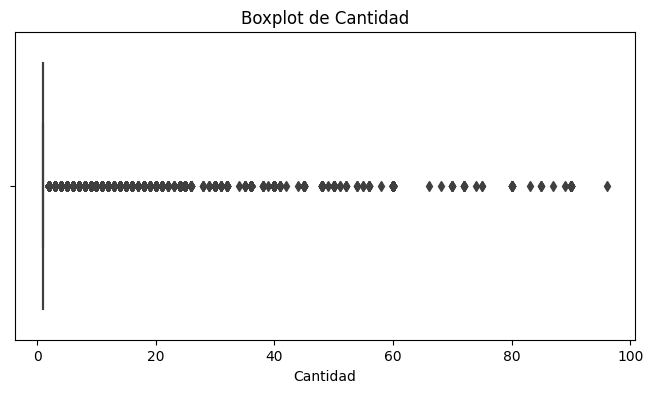

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


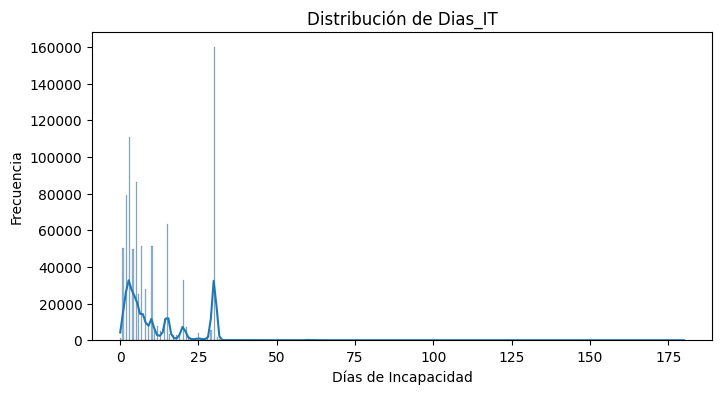

In [48]:
# Distribución de Cantidad
plt.figure(figsize=(8,4))
sns.histplot(df_salud['Cantidad'], kde=True)
plt.title("Distribución de Cantidad")
plt.xlabel("Cantidad")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot para detectar outliers en Cantidad
plt.figure(figsize=(8,4))
sns.boxplot(x=df_salud['Cantidad'])
plt.title("Boxplot de Cantidad")
plt.show()

# Distribución de Dias_IT
plt.figure(figsize=(8,4))
sns.histplot(df_salud['Dias_IT'], kde=True)
plt.title("Distribución de Dias_IT")
plt.xlabel("Días de Incapacidad")
plt.ylabel("Frecuencia")
plt.show()


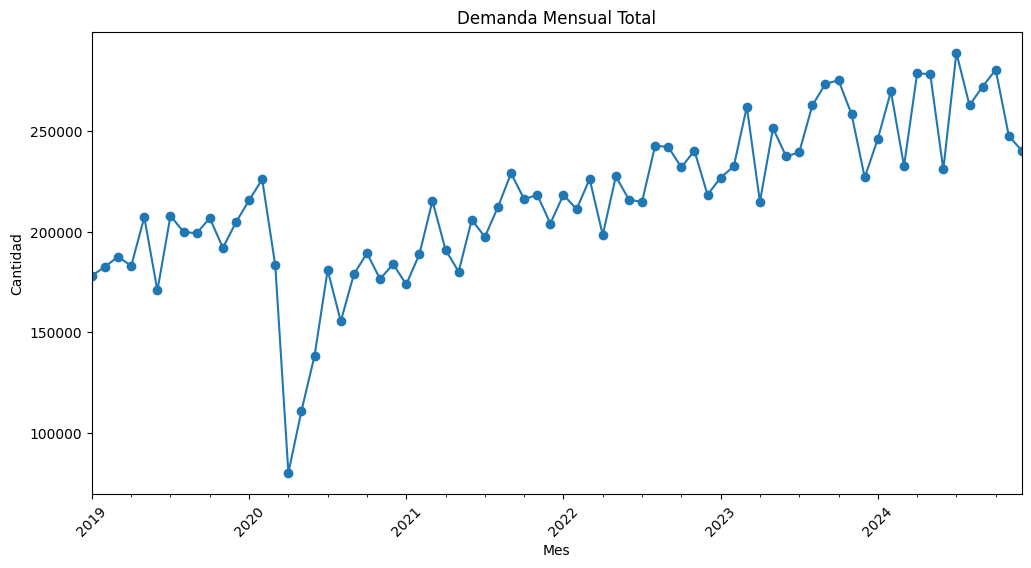

In [49]:
# Asegurarse de que FECHA_ATENCION es datetime (ya se parseó en la carga)
df_salud['Mes'] = df_salud['FECHA_ATENCION'].dt.to_period('M')

# Agrupar la demanda (Cantidad) por mes
demanda_por_mes = df_salud.groupby('Mes')['Cantidad'].sum().sort_index()

plt.figure(figsize=(12,6))
demanda_por_mes.plot(marker='o')
plt.title("Demanda Mensual Total")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()
